# classification-02

## What's new:

1-




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from scipy.signal import savgol_filter, find_peaks, peak_prominences
import talib


2025-10-20 19:12:07.956999: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 19:12:07.990415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])


# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)

# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

In [3]:
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,  # 0.15% minimum leg size
        min_dev_sigma=2.0,  # >= 2x local abs-return EMA
        vol_window=100,  # EMA window for local volatility
        verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:  # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n - 1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [5]:
# baseline (close-only)
df['Label'] = label_reversal_points(df['CLOSE'].values, verbose=True)

# inspect counts
print(df['Label'].value_counts())

labels -> 0:97960  1:1019  2:1021  (extrema kept: 2038)
Label
0    97960
2     1021
1     1019
Name: count, dtype: int64


In [5]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

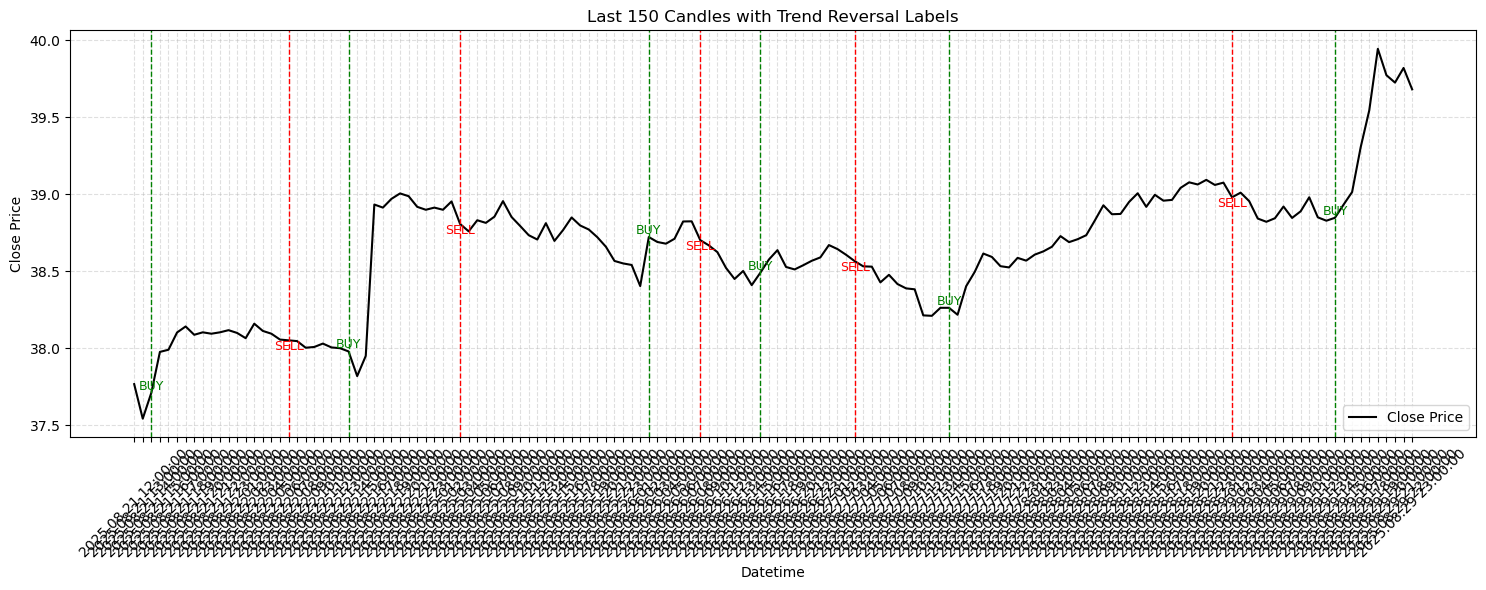

In [6]:
plot_labeled_candles(df)

In [7]:
# 3- Prepare Sequences

given_time = "2024.05.03 01:00:00"   # starting datetime
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
X, y = [], []

for i in range(WINDOW_SIZE, len(scaled) - FORECAST_HORIZON):
    X_seq = scaled[i - WINDOW_SIZE:i]  # (60, 5)
    y_seq = df['Label'].iloc[i:i + FORECAST_HORIZON].values  # 10 labels (0/1/2)
    X.append(X_seq)
    y.append(y_seq)

X = np.array(X)  # shape: (samples, 60, 5)
y = np.array(y)  # shape: (samples, 10)

In [8]:
# 4- Split dataset
# Reserve last sample as test input
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1:], y[-1:]

In [9]:
# 5- One-hot encode each timestep's class (3 classes → depth = 3)
# Convert labels to one-hot for each timestep
y_train_onehot = np.array([to_categorical(seq, num_classes=3) for seq in y_train])
y_test_onehot = np.array([to_categorical(seq, num_classes=3) for seq in y_test])


In [10]:
# 6- Build LSTM Classification Model
model = Sequential([
    Input(shape=(WINDOW_SIZE, X.shape[2])),  # (60, 5)
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(3, activation='softmax')),
    Lambda(lambda x: x[:, -FORECAST_HORIZON:, :])  # Keep only last 10 timesteps
])


I0000 00:00:1760117142.263533    3347 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2383 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [11]:
# 7- Compile model

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')
    ]
)

In [12]:
# 8- Fit model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train_onehot,
    epochs=50,  # adjust based on convergence
    batch_size=64,
    validation_split=0.1,
    shuffle=False,  # Important: keep time order!
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


I0000 00:00:1760117152.608913    3423 cuda_dnn.cc:529] Loaded cuDNN version 91301


1406/1406 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9159 - loss: 0.3513 - top_2_accuracy: 0.9582 - val_accuracy: 0.9146 - val_loss: 0.3518 - val_top_2_accuracy: 0.9573
Epoch 2/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9165 - loss: 0.3460 - top_2_accuracy: 0.9583 - val_accuracy: 0.9146 - val_loss: 0.3513 - val_top_2_accuracy: 0.9573
Epoch 3/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9165 - loss: 0.3457 - top_2_accuracy: 0.9582 - val_accuracy: 0.9146 - val_loss: 0.3512 - val_top_2_accuracy: 0.9573
Epoch 4/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9165 - loss: 0.3456 - top_2_accuracy: 0.9581 - val_accuracy: 0.9146 - val_loss: 0.3510 - val_top_2_accuracy: 0.9573
Epoch 5/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.9165 - loss: 0.3453 - top_2_accuracy: 0.9583 - val_accuracy: 0.9146 - val_loss: 0.3509 - val_top_2_accuracy: 0.9573
Epoch 6/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.9165 - loss

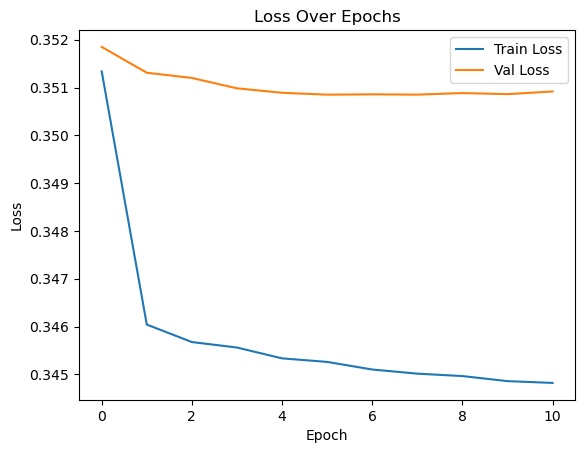

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# === Load and clean the last 60 rows from a separate CSV file for prediction ===
# --- Find the starting index ---
start_idx = df.index[df['DATETIME'] == pd.to_datetime(given_time)][0]

# --- 1. Extract next n candles ---
input_df = df.iloc[start_idx : start_idx + WINDOW_SIZE].copy()


# Scale
input_features = input_df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']]
input_scaled = scaler.transform(input_features)
input_sequence = np.expand_dims(input_scaled, axis=0)  # (1, 60, 5)

# Predict
pred_probs = model.predict(input_sequence)  # shape: (1, 10, 3)
pred_classes = np.argmax(pred_probs[0], axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# Timestamps for forecast
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=FORECAST_HORIZON, freq='h')

# Output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': datetime_index,
    'forecast_class': pred_classes
})
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
Predicted Classes: [0 0 0 0 0 0 0 0 0 0]
             DATETIME  forecast_class label
0 2024-05-07 15:00:00               0      
1 2024-05-07 16:00:00               0      
2 2024-05-07 17:00:00               0      
3 2024-05-07 18:00:00               0      
4 2024-05-07 19:00:00               0      
5 2024-05-07 20:00:00               0      
6 2024-05-07 21:00:00               0      
7 2024-05-07 22:00:00               0      
8 2024-05-07 23:00:00               0      
9 2024-05-08 00:00:00               0      


# plot section

In [15]:
# --- 2. Extract last 4 candles from input_df ---
historical_df = input_df.tail(4).copy()

# --- 3. Extract next 10 candles immediately after input_df ---
actual_future_df = df.iloc[start_idx + WINDOW_SIZE - 1 : start_idx + WINDOW_SIZE + FORECAST_HORIZON].copy()

plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'


# 10-3 Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=FORECAST_HORIZON, freq='h')

# 10-4 Create predicted_df with forecasted trend reversals
predicted_df = pd.DataFrame({
    'DATETIME': datetime_index,
    'forecast_class': pred_classes
})


# 10-5 Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None


predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


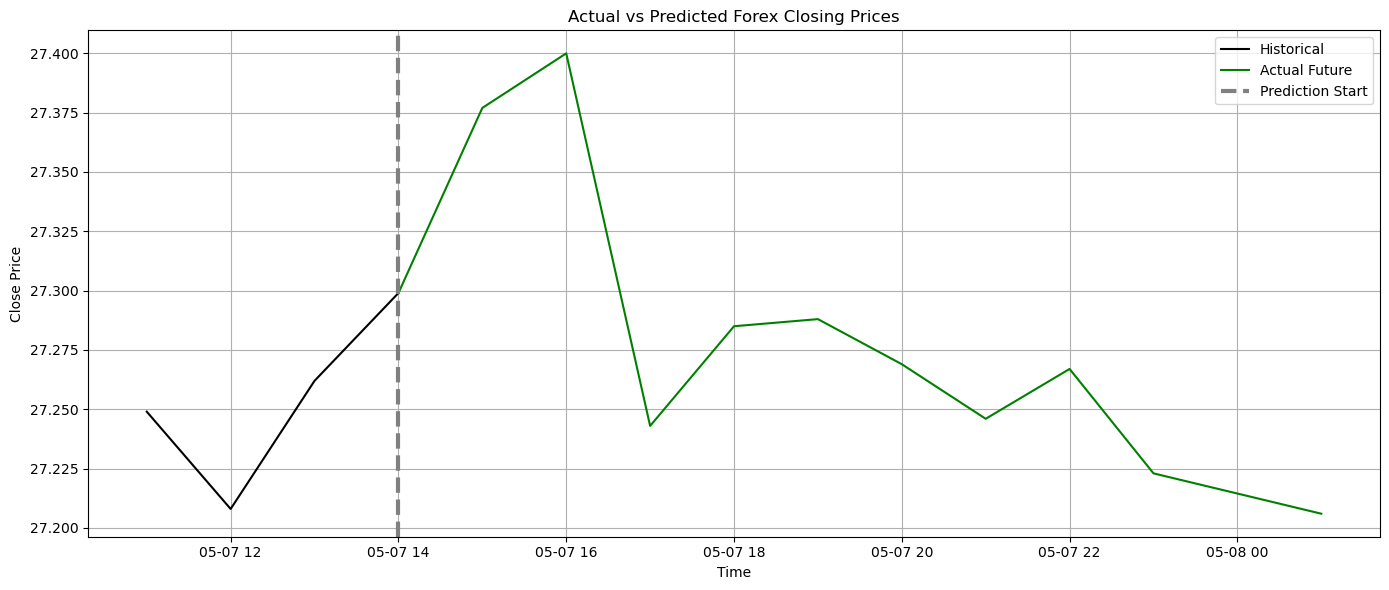

In [17]:
# 10-6 PLOT

import sys
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# PLOT
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)



In [18]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy, final_test_mae = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')